In [1]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import label_map_util
from utils import visualization_utils as vis_util
import random

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [3]:
## Test model
# PATH_TO_GRAPH = r'models/rcnn_resnet101/frozen_inference_graph.pb'
# PATH_TO_GRAPH = r'models/rcnn/frozen_inference_graph.pb'
PATH_TO_GRAPH = r'models/ssd_udacity/frozen_inference_graph.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'data/udacity_label_map.pbtxt'
NUM_CLASSES = 13

In [4]:
detection_graph = load_graph(PATH_TO_GRAPH)

In [5]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [6]:
IMAGE_SIZE = (12, 8)

SCORES
[0.5306786  0.04019547 0.03805515 0.02580015 0.02401508 0.02346014
 0.0233491  0.02325931 0.02211214 0.02199029]
CLASSES
[1. 3. 1. 2. 1. 1. 1. 1. 2. 3.]


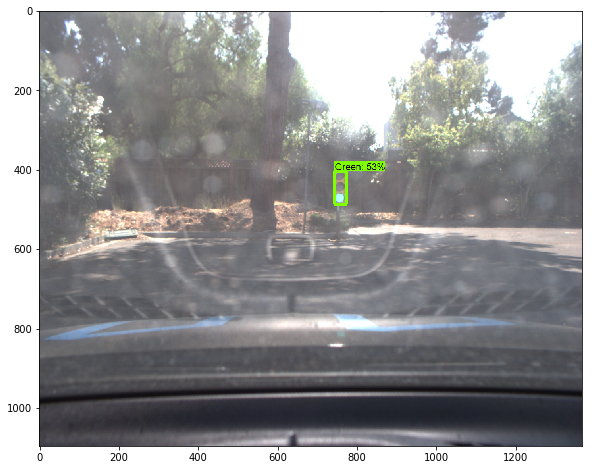

SCORES
[0.49584258 0.12603423 0.02995498 0.02642234 0.02596424 0.02503493
 0.02460641 0.0236321  0.02261512 0.02163593]
CLASSES
[1. 1. 1. 3. 4. 2. 4. 4. 2. 1.]


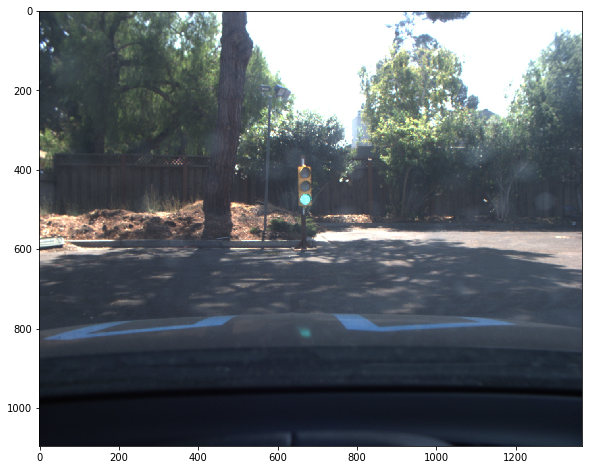

SCORES
[0.9858056  0.02718669 0.02538889 0.02475221 0.02411382 0.02364574
 0.0223495  0.02232776 0.02216983 0.02195143]
CLASSES
[1. 3. 3. 1. 4. 3. 4. 1. 4. 3.]


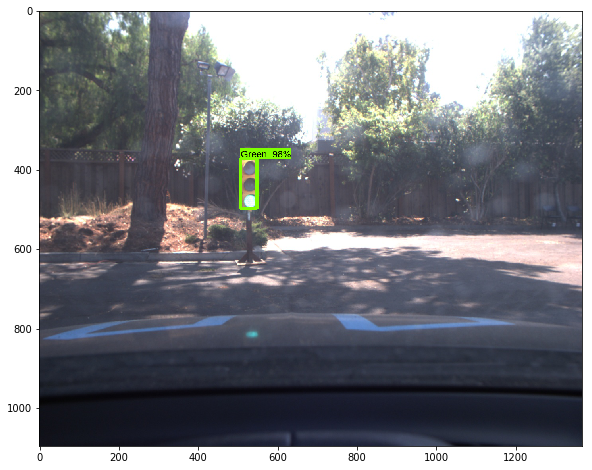

SCORES
[0.87146294 0.02982922 0.02911683 0.02708915 0.02692564 0.02675021
 0.02401558 0.02316775 0.02314394 0.02219582]
CLASSES
[2. 3. 3. 2. 1. 2. 3. 4. 3. 4.]


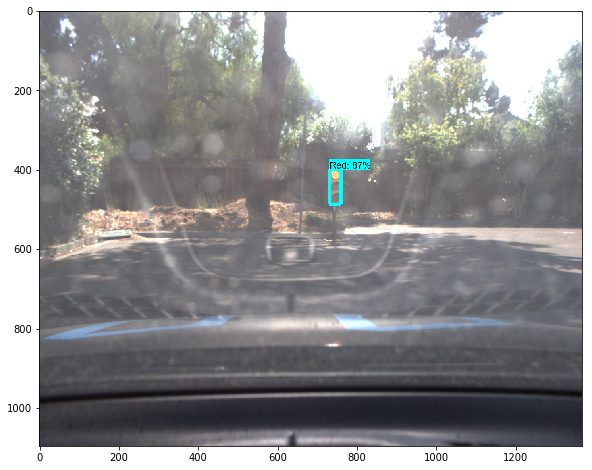

SCORES
[0.4600461  0.06666617 0.02698432 0.02617588 0.02286233 0.02276756
 0.02177341 0.0216211  0.02114341 0.02095914]
CLASSES
[2. 3. 4. 3. 3. 3. 4. 3. 1. 2.]


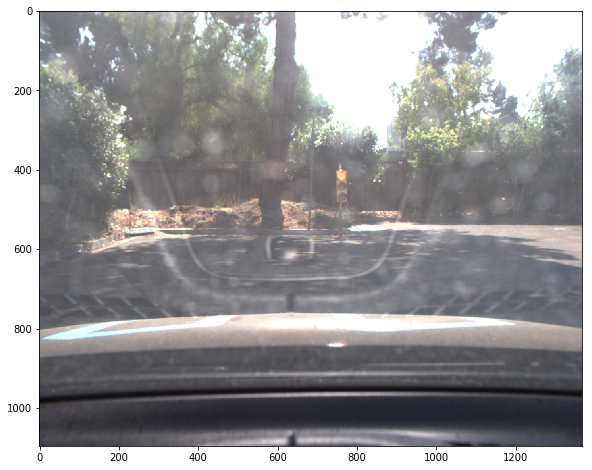

SCORES
[0.50722766 0.02814934 0.02665065 0.02488384 0.02479133 0.0233163
 0.02246197 0.02176917 0.02144161 0.02103449]
CLASSES
[1. 4. 1. 4. 2. 4. 1. 1. 2. 3.]


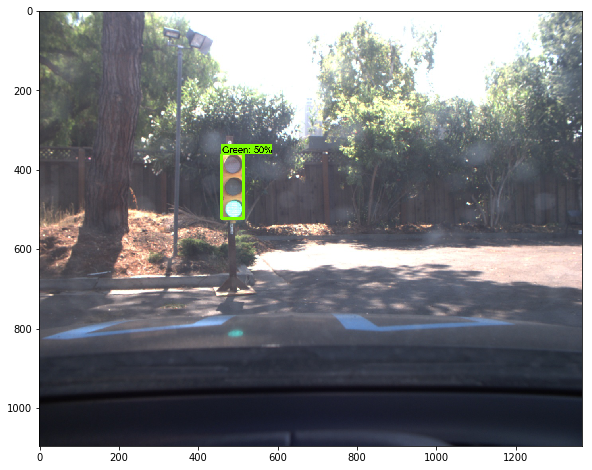

SCORES
[0.9262984  0.03893255 0.02880448 0.02795748 0.02734341 0.02599149
 0.02576342 0.02345358 0.0222946  0.0220483 ]
CLASSES
[1. 1. 3. 3. 1. 1. 3. 4. 3. 2.]


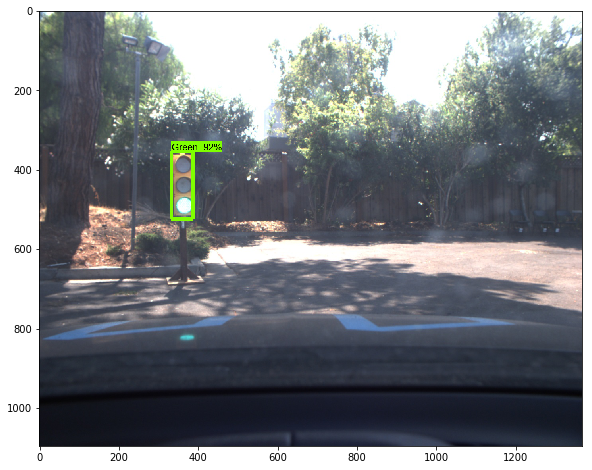

SCORES
[0.6620791  0.02891117 0.02550698 0.02472732 0.02364126 0.0234693
 0.02337988 0.02329829 0.02217935 0.02146756]
CLASSES
[2. 3. 1. 4. 3. 1. 2. 3. 2. 3.]


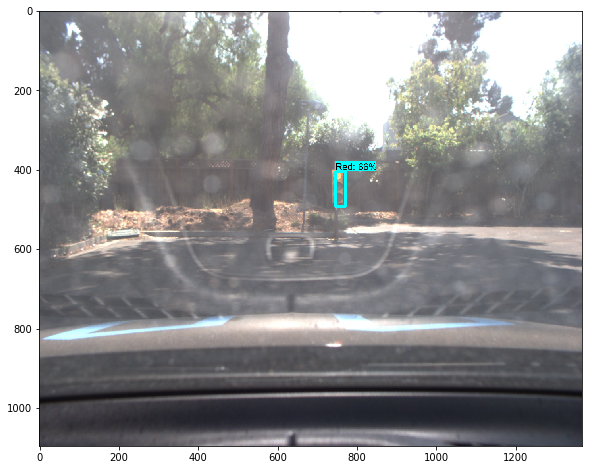

SCORES
[0.5306786  0.04019547 0.03805515 0.02580015 0.02401508 0.02346014
 0.0233491  0.02325931 0.02211214 0.02199029]
CLASSES
[1. 3. 1. 2. 1. 1. 1. 1. 2. 3.]


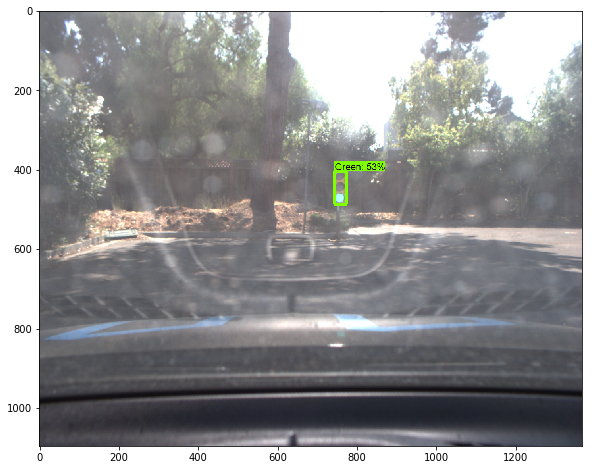

SCORES
[0.19831969 0.16828558 0.06418136 0.02956449 0.02873974 0.02632081
 0.02200457 0.022      0.02171006 0.02133563]
CLASSES
[2. 3. 1. 3. 4. 3. 3. 4. 4. 2.]


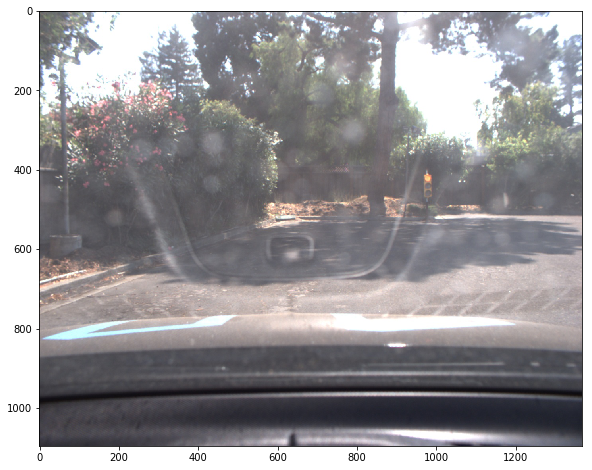

SCORES
[0.53484195 0.0583798  0.02569129 0.02395854 0.02302114 0.02226589
 0.02191656 0.02190218 0.02079714 0.02056567]
CLASSES
[2. 3. 1. 3. 3. 1. 2. 3. 3. 4.]


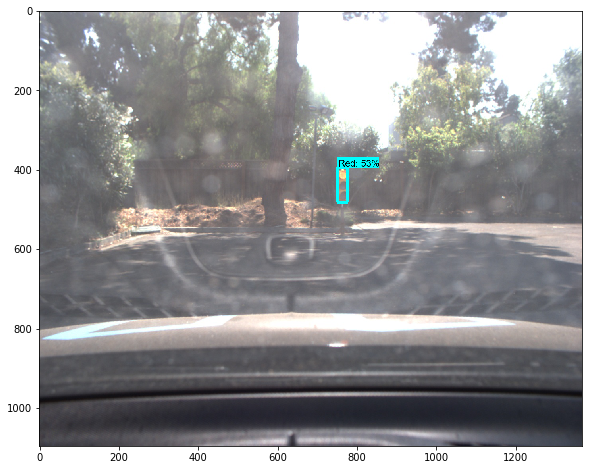

In [7]:
PATH_TO_IMGS = r'data/udacity_testarea_rgb'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            random.shuffle(TEST_IMGS)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break

In [8]:
PATH_TO_GRAPH = r'models/ssd_sim/frozen_inference_graph.pb' ## load SSD trained on udacity's simulator images
detection_graph = load_graph(PATH_TO_GRAPH)

SCORES
[0.71692526 0.6057687  0.40411663 0.00872206 0.00752667 0.00714995
 0.0068589  0.00623947 0.00595293 0.00588816]
CLASSES
[2. 2. 2. 1. 1. 2. 2. 3. 3. 1.]


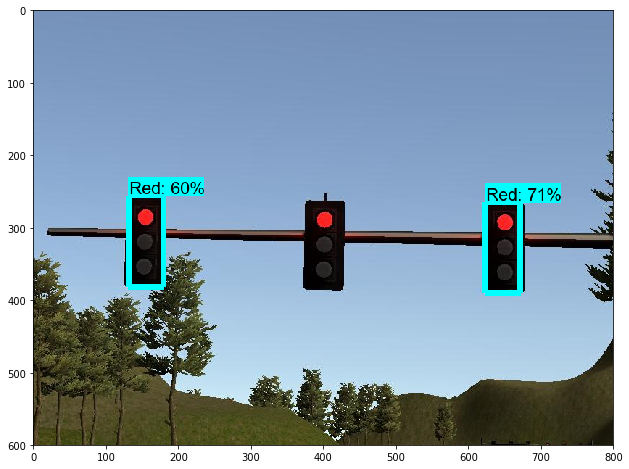

SCORES
[0.01520706 0.01185621 0.0114532  0.01118233 0.01094338 0.01054533
 0.0101359  0.01011213 0.00957582 0.00941148]
CLASSES
[4. 1. 3. 4. 1. 1. 1. 3. 2. 1.]


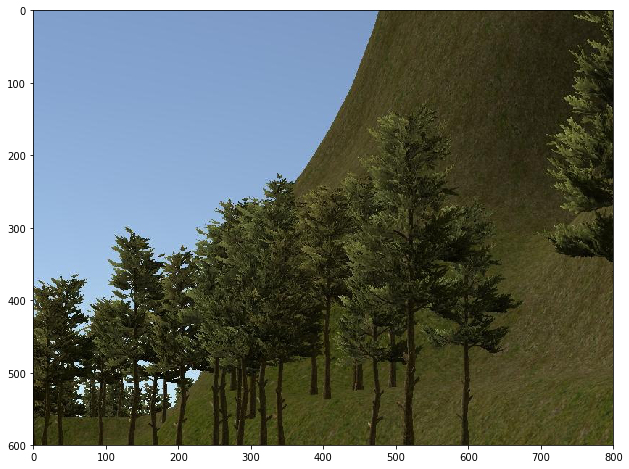

SCORES
[0.72798276 0.56912667 0.40518463 0.00733046 0.0071938  0.00716086
 0.00636751 0.00614053 0.00591381 0.00558107]
CLASSES
[2. 2. 2. 1. 2. 1. 3. 2. 1. 3.]


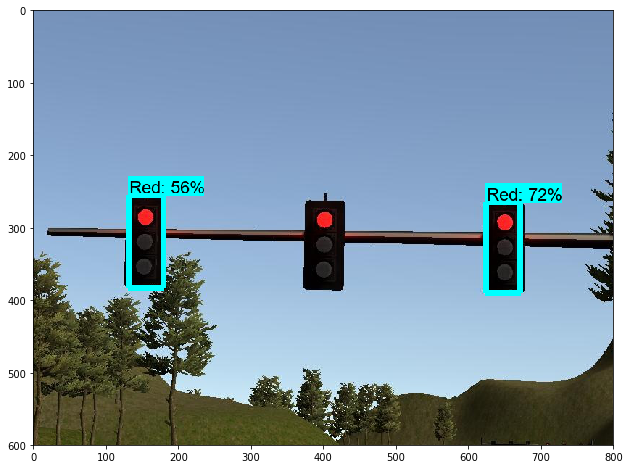

SCORES
[0.75544524 0.71155053 0.6783157  0.00791133 0.00766311 0.00701929
 0.0056298  0.00529498 0.00495196 0.00488837]
CLASSES
[1. 1. 1. 3. 1. 3. 3. 1. 3. 1.]


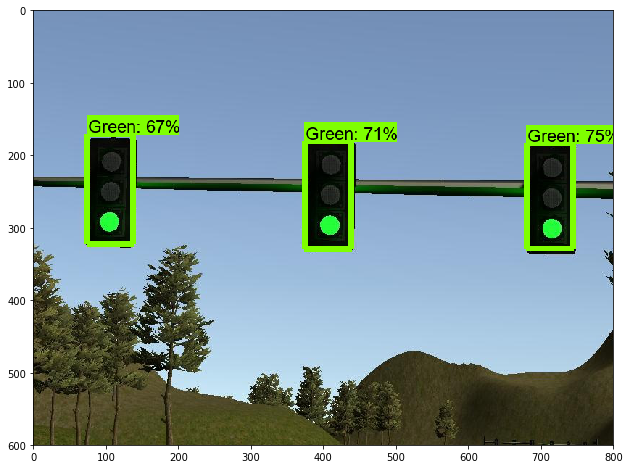

SCORES
[0.0675588  0.066354   0.06025207 0.04519444 0.04471028 0.04123871
 0.03680717 0.03354503 0.02214608 0.02131601]
CLASSES
[2. 2. 1. 4. 4. 2. 3. 3. 2. 2.]


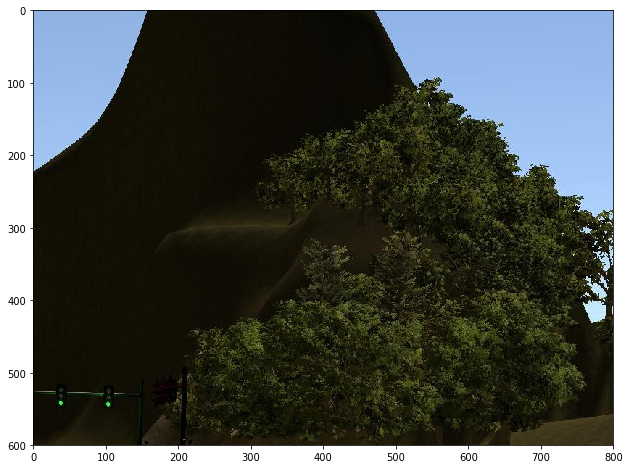

SCORES
[0.77763087 0.14633836 0.02681616 0.02308211 0.02153297 0.01903132
 0.01859229 0.01587056 0.01568301 0.0128895 ]
CLASSES
[2. 2. 1. 4. 4. 2. 1. 1. 2. 2.]


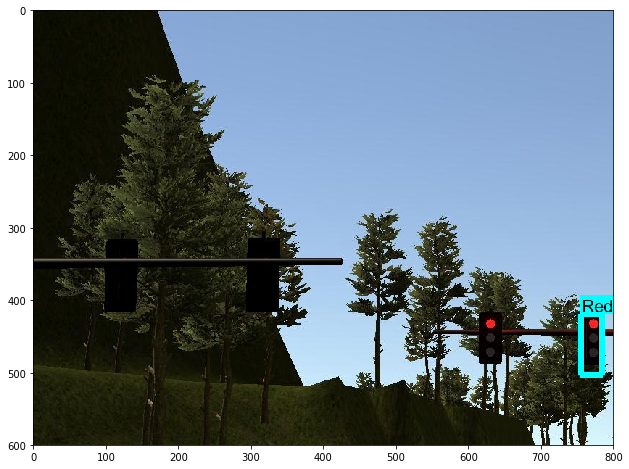

SCORES
[0.05337058 0.02503736 0.01302116 0.01146357 0.0101985  0.00922816
 0.00778391 0.00759372 0.00726272 0.00674203]
CLASSES
[2. 2. 2. 1. 2. 1. 4. 3. 3. 3.]


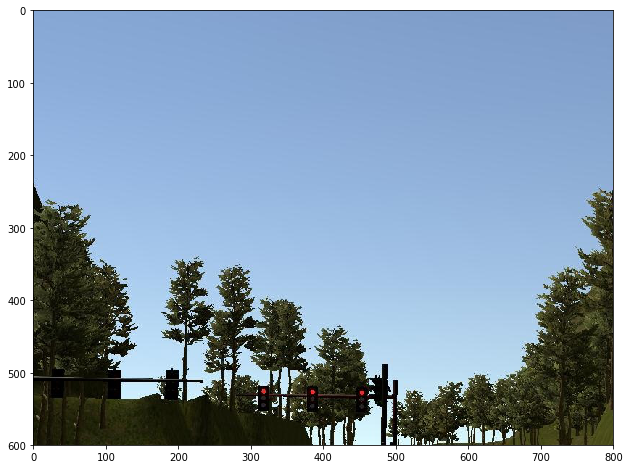

SCORES
[0.19873723 0.18208948 0.09076142 0.06261755 0.06101187 0.05426874
 0.04970329 0.04685179 0.04402616 0.04322167]
CLASSES
[2. 1. 1. 2. 3. 4. 1. 1. 2. 3.]


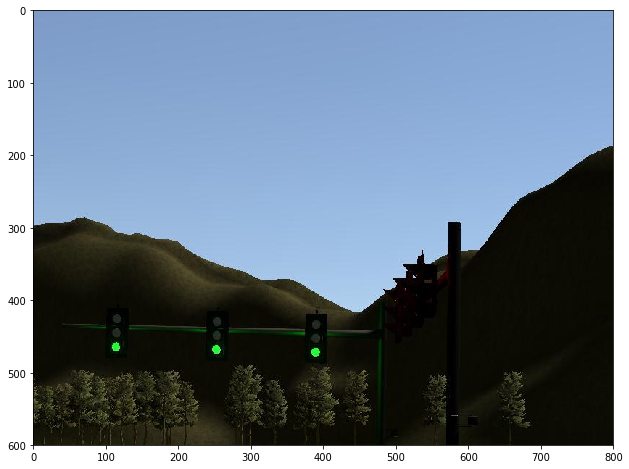

SCORES
[0.916227   0.47482258 0.3231594  0.02313959 0.01435313 0.01408837
 0.01314891 0.01314649 0.01189136 0.01108174]
CLASSES
[2. 2. 2. 1. 2. 1. 3. 1. 1. 1.]


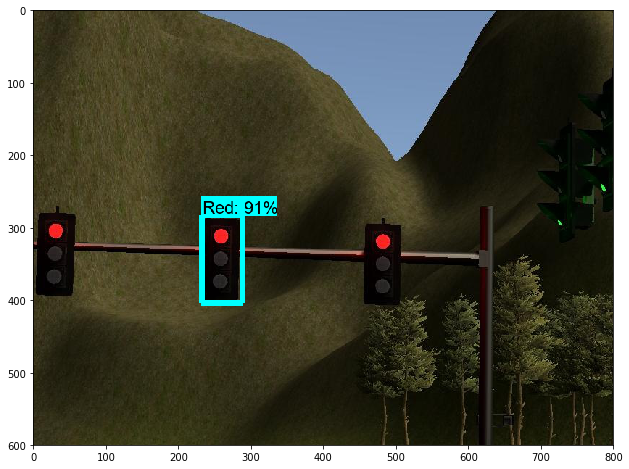

SCORES
[0.866176   0.6074205  0.05835014 0.01850744 0.01787555 0.01706965
 0.0160633  0.01457934 0.01282972 0.01230013]
CLASSES
[3. 3. 1. 1. 1. 3. 1. 1. 2. 1.]


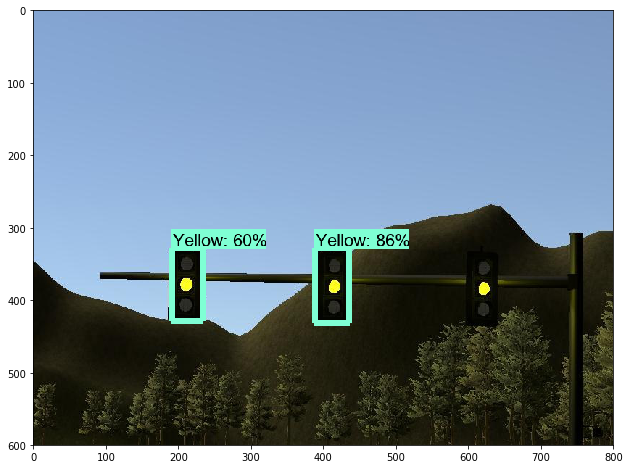

SCORES
[0.73734885 0.5945593  0.4098383  0.00732442 0.00716316 0.0071612
 0.00631169 0.00621201 0.00590658 0.00569111]
CLASSES
[2. 2. 2. 1. 2. 1. 3. 2. 1. 3.]


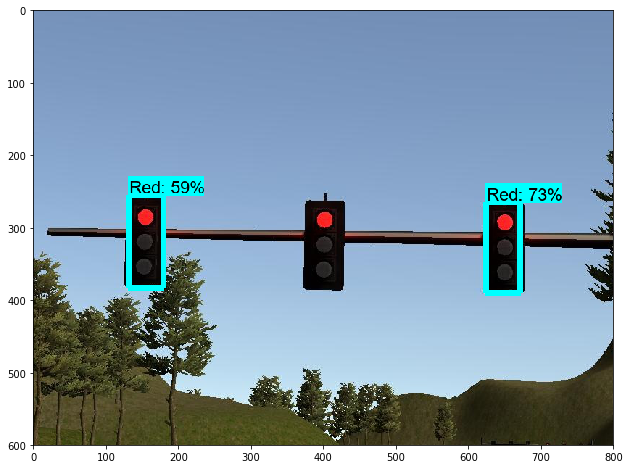

In [9]:
PATH_TO_IMGS = r'data/simulator_dataset_rgb'
subfolder = ['Green', 'Red', 'Yellow', 'Unknown']
TEST_IMGS = []
for i in subfolder:
    TEST_IMGS += glob(os.path.join(os.path.join(PATH_TO_IMGS, i), r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break